<a href="https://colab.research.google.com/github/yleessam/tf/blob/main/object_detecting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

정지 영상에서 객체 탐지

In [ ]:
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
# YOLO 구성 및 가중치 파일 다운로드
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true -O yolov3.cfg
!wget https://github.com/pjreddie/darknet/blob/master/data/coco.names?raw=true -O coco.names

--2024-01-26 18:50:05--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  22.2MB/s    in 10s     

2024-01-26 18:50:15 (22.6 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2024-01-26 18:50:15--  https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg [following]
--2024-01-26 18:50:16--  https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg
Reusing existing connection to github.com:443.
HTTP request sent, awaiti

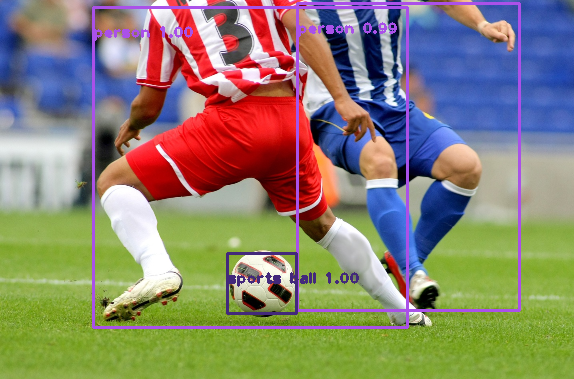

In [ ]:
# 이미지 파일을 업로드하거나 다운로드합니다.
# 예시로 사용할 이미지 파일을 직접 업로드하거나 아래 wget 명령어로 다운로드 할 수 있습니다.
# !wget <이미지 파일 URL> -O image.jpg

def load_yolo():
    net = cv.dnn.readNet("yolov3.weights", "yolov3.cfg")
    with open("coco.names", "r") as f:
        classes = [line.strip() for line in f.readlines()]
    layers_names = net.getLayerNames()
    output_layers = [layers_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]
    colors = np.random.uniform(0, 255, size=(len(classes), 3))
    return net, classes, colors, output_layers

def load_image(img_path):
    # 이미지를 불러오고, YOLO 입력 크기로 크기를 조정합니다.
    img = cv.imread(img_path)
    img = cv.resize(img, None, fx=0.4, fy=0.4)
    height, width, channels = img.shape
    return img, height, width, channels

def detect_objects(img, net, outputLayers):
    blob = cv.dnn.blobFromImage(img, scalefactor=0.00392, size=(416, 416), mean=(0, 0, 0), swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(outputLayers)
    return blob, outputs

def get_box_dimensions(outputs, height, width):
    boxes = []
    confs = []
    class_ids = []
    for output in outputs:
        for detect in output:
            scores = detect[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detect[0] * width)
                center_y = int(detect[1] * height)
                w = int(detect[2] * width)
                h = int(detect[3] * height)

                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confs.append(float(confidence))
                class_ids.append(class_id)
    return boxes, confs, class_ids

def draw_labels(boxes, confs, colors, class_ids, classes, img):
    indexes = cv.dnn.NMSBoxes(boxes, confs, 0.5, 0.4)
    font = cv.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            confidence = confs[i]
            color = colors[class_ids[i]]
            cv.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv.putText(img, f"{label} {confidence:.2f}", (x, y + 30), font, 1, color, 2)
    cv2_imshow(img)

net, classes, colors, output_layers = load_yolo()
image, height, width, channels = load_image("soccer.jpg")

blob, outputs = detect_objects(image, net, output_layers)  # 이 부분을 수정했습니다.
boxes, confs, class_ids = get_box_dimensions(outputs, height, width)
draw_labels(boxes, confs, colors, class_ids, classes, image)


비디오에서 객체 탐지

Google Colab에서 웹캠을 사용하여 비디오 스트림에서 객체를 탐지하는 것은 직접적으로는 지원되지 않습니다. 이는 Colab이 브라우저 기반 환경이며, 보안상의 이유로 로컬 하드웨어에 직접 접근할 수 없기 때문입니다.

그러나, JavaScript를 사용하여 브라우저를 통해 웹캠으로부터 이미지를 캡처하고, 그 이미지를 Python으로 전송하여 처리한 후 결과를 다시 출력하는 방법이 있습니다. 이 접근 방식은 실시간 비디오 처리보다는 개별 이미지 처리에 더 가깝습니다.

아래의 코드는 Colab에서 웹캠을 사용하여 사진을 찍고, 이를 YOLO 모델로 객체 탐지를 하는 예제를 보여줍니다:

<IPython.core.display.Javascript object>

Saved to photo.jpg


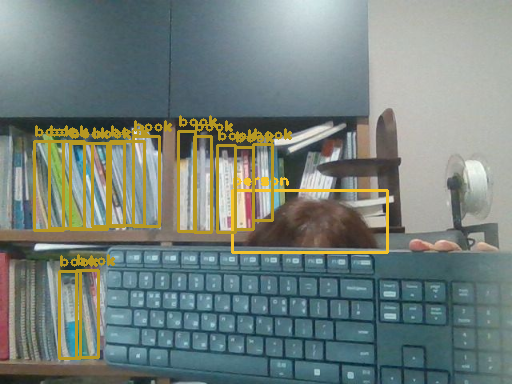

In [ ]:
# 필요한 라이브러리 불러오기
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

# YOLO 모델을 로드하는 함수
def load_yolo():
    net = cv.dnn.readNet("yolov3.weights", "yolov3.cfg")
    with open("coco.names", "r") as f:
        classes = [line.strip() for line in f.readlines()]
    layers_names = net.getLayerNames()
    output_layers = [layers_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]
    colors = np.random.uniform(0, 255, size=(len(classes), 3))
    return net, classes, colors, output_layers

# 이미지를 불러오는 함수
def load_image(img_path):
    img = cv.imread(img_path)
    img = cv.resize(img, None, fx=0.8, fy=0.8) #사진 크기
    height, width, channels = img.shape
    return img, height, width, channels

# 객체 탐지를 수행하는 함수
def detect_objects(img, net, output_layers):
    blob = cv.dnn.blobFromImage(img, scalefactor=0.00392, size=(416, 416), mean=(0, 0, 0), swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(output_layers)
    return outputs  # blob을 반환할 필요가 없습니다.

# 탐지된 객체의 정보를 추출하는 함수
def get_box_dimensions(outputs, height, width):
    boxes = []
    confs = []
    class_ids = []
    for output in outputs:
        for detect in output:
            scores = detect[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detect[0] * width)
                center_y = int(detect[1] * height)
                w = int(detect[2] * width)
                h = int(detect[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confs.append(float(confidence))
                class_ids.append(class_id)
    return boxes, confs, class_ids

# 바운딩 박스와 레이블을 이미지에 그리는 함수
def draw_labels(boxes, confs, colors, class_ids, classes, img):
    indexes = cv.dnn.NMSBoxes(boxes, confs, 0.5, 0.4)
    font = cv.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = colors[class_ids[i]]
            cv.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv.putText(img, label, (x, y - 5), font, 1, color, 2)
    cv2_imshow(img)

# JavaScript를 이용해 웹캠으로부터 사진을 찍는 함수입니다.
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# YOLO 모델과 필요한 함수들을 여기에 정의합니다. (위의 예제 코드 참고)

# 웹캠으로부터 사진을 찍습니다.
try:
    filename = take_photo() # 'photo.jpg'로 저장됩니다.
    print('Saved to {}'.format(filename))

    # YOLO로 객체 탐지를 수행합니다.
    # 이 부분에서 함수를 올바르게 호출합니다.
    net, classes, colors, output_layers = load_yolo()
    image, height, width, channels = load_image("photo.jpg")  # 파일 이름을 확인하세요
    outputs = detect_objects(image, net, output_layers)  # blob 반환을 제거했습니다.
    boxes, confs, class_ids = get_box_dimensions(outputs, height, width)
    draw_labels(boxes, confs, colors, class_ids, classes, image)
except Exception as e:
    print(str(e))